# Coding project - Tumour segmentation
The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²).

First, we will read and display the image.

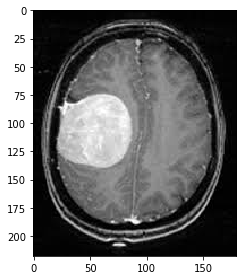

In [2]:
from skimage.io import imread,imshow
%matplotlib inline

brainImage = imread('mri_brain.jpg')
imshow(brainImage)

The tumor is made of 3545 pixels
The area of the tumor is 46.882625000000004 cm²


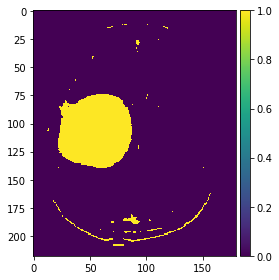

In [119]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.io import imread,imshow
from skimage.measure import label,regionprops
from skimage.morphology import disk
from skimage.color import rgb2gray
from PIL import Image
%matplotlib inline

#read the original MRI
brainImage = Image.open('mri_brain.jpg')

lut_thresh = np.zeros((256,))
t = 160
for i in range(t): lut_thresh[i] = 0
for i in range(t,256): lut_thresh[i] = i 
brainImage = lut_thresh[brainImage]

brainImage = (brainImage[:,:,0]>0).astype(int)

imshow(brainImage)
#extract connected components
label = label(brainImage, connectivity=1)

#Measure properties of labeled image regions
props = regionprops(label_img)

#Get the bigest region
tumorArea = 0
for prop in props:
    if(prop.area > tumorArea):
        tumorArea = prop.area

print("The tumor is made of " + str(tumorArea) + " pixels")
#Convert the pixel area in cm 
tumorArea = 0.013225 * tumorArea
print("The area of the tumor is " + str(tumorArea) + " cm²")

